In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator
import pinyin

In [2]:
files = [file for file in os.listdir("Station_data")]

In [3]:
rows = []
for file in files:
    with open("./Station_Data/" + file) as f:
        lines = f.readlines()[1:]
        lines = [line.split(",") for line in lines]
        for line in lines:
            rows.append((file, line[0], line[1].strip("\n")))

In [4]:
ridership = pd.DataFrame(rows, columns=["station_1", "station_2", "trains"])
lines = gpd.read_file("./stations_geo/China_HSR_2016_lines.shp")
stations = gpd.read_file("./stations_geo/China_HSR_2016_stations.shp")

---

In [5]:
strip_list = [" Railway Station"]
end_strip_list = ["bei", "xi", "nan", "dong"]


def strip_from_list(s: str):
    for item in strip_list:
        s = s.replace(item, "")

    for item in end_strip_list:
        if s[len(s) - len(item):] == item:
            s = s[: len(s) - len(item)]

    return s.lower()


ridership["s1_strip"] = ridership["station_1"].apply(lambda x: strip_from_list(x))
ridership["s2_strip"] = ridership["station_2"].apply(lambda x: strip_from_list(x))
ridership["trains"] = ridership["trains"].astype(int)

In [6]:
multi_stations = pd.DataFrame(ridership.groupby(by=["s1_strip", "s2_strip"])["trains"].sum()).reset_index()

In [7]:
ridership = ridership.merge(multi_stations, on=["s1_strip", "s2_strip"], how="left")
ridership = ridership.drop(columns=["trains_x"]).rename(columns={"trains_y": "trains"})
ridership = ridership.drop_duplicates(subset=["s1_strip", "s2_strip"])
# add dist
# change city boundary to lower and fix names

In [8]:
stations["romanized"] = stations["NAME_ZH"].apply(
    lambda x: pinyin.get(x, format="strip")
)
stations["romanized"] = stations["romanized"].apply(lambda x: strip_from_list(x))
stations.head(3)

,OBJECTID,NAME_ZH,speed_kph,line_name,KML_FOLDER,geometry,romanized
0,1,华容,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (114.73729 30.52040 0.00000),huarong
1,2,黄石,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (114.93489 30.15640 0.00000),huangshi
2,3,阳新,200,武九线/车站,200+ upgraded conventional/武九线/车站,POINT Z (115.17481 29.86132 0.00000),yangxin


In [9]:
rider = set(ridership["s1_strip"]).difference(set(stations["romanized"]))
print(len(rider))
in_harvard = set(stations["romanized"]).difference(set(ridership["s1_strip"]))
print(len(in_harvard))

222
225


In [10]:
stations_w_riders = ridership.merge(
    stations[["geometry", "romanized"]],
    how="left",
    left_on="s1_strip",
    right_on="romanized",
).merge(
    stations[["geometry", "romanized"]],
    how="left",
    left_on="s2_strip",
    right_on="romanized",
)

print(len(stations_w_riders))

stations_w_riders = stations_w_riders.dropna(subset="geometry_x")
stations_w_riders = stations_w_riders.dropna(subset="geometry_y")
len(stations_w_riders)

11610


9551

In [11]:
stations_riders_geo = gpd.GeoDataFrame(stations_w_riders).set_geometry("geometry_x")

stations_riders_geo["geometry_x"] = gpd.GeoSeries(
    stations_riders_geo["geometry_x"]
).to_crs("epsg:3857")

stations_riders_geo["geometry_y"] = gpd.GeoSeries(
    stations_riders_geo["geometry_y"]
).to_crs("epsg:3857")

stations_riders_geo["dist"] = stations_riders_geo["geometry_x"].distance(
    stations_riders_geo["geometry_y"]
)

In [26]:
stations_riders_geo = stations_riders_geo.rename(
    columns={
        "romanized_x": "city1",
        "romanized_y": "city2",
    }
)
stations_riders_geo["dist"] = stations_riders_geo["dist"] / 1000
stations_riders_geo.sample(3)

,station_1,station_2,s1_strip,s2_strip,trains,geometry_x,city1,geometry_y,city2,dist
8125,Shijiazhuang Railway Station,Shanghaihongqiao Railway Station,shijiazhuang,shanghaihongqiao,221,POINT Z (12730413.080 4589844.596 0.000),shijiazhuang,POINT Z (13504866.490 3658229.254 0.000),shanghaihongqiao,1.211481
6497,Pingxiangbei Railway Station,Fuzhou Railway Station,pingxiang,fuzhou,31,POINT Z (12672854.380 3209679.823 0.000),pingxiang,POINT Z (13289947.023 2997697.756 0.000),fuzhou,0.652487
4701,Jinanxi Railway Station,Dalianbei Railway Station,ji,dalian,82,POINT Z (13011676.230 4393063.670 0.000),ji,POINT Z (13539553.718 4710480.937 0.000),dalian,0.615961


In [27]:
stations_riders_geo.to_parquet("./data/china_city_riders.parquet", index=False)
stations_riders_geo.to_csv("./data/china_city_riders.csv", index=False)

In [19]:
metros = pd.read_parquet("./data/metro_regions.parquet")
metros["metro"] = metros["metro"].str.lower()

<Axes: >

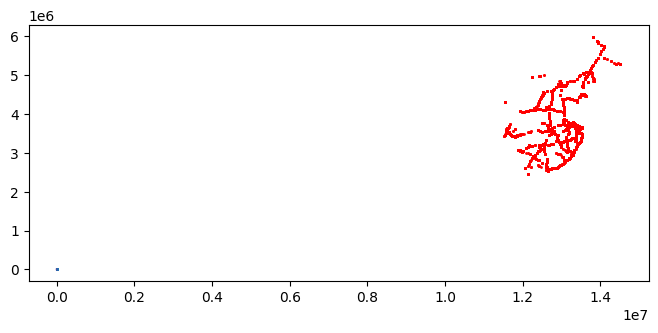

In [20]:
fig, ax = plt.subplots(figsize=(8,8))
lines.plot(ax=ax, color="purple", markersize=0.01, alpha=0.2)
stations.plot(ax=ax, markersize=1)
stations_riders_geo.plot(ax=ax, color="red", markersize=1)